In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline
import sys
#!{sys.executable} -m pip install -U imbalanced-learn
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

### Leitura dos dados

In [19]:
dados = pd.read_csv("train.csv")
#dados_teste = pd.read_csv("eleicoes_2014.csv")
#dados_teste.columns = ["ano","sequencial_candidato","nome","uf","partido","quantidade_doacoes","quantidade_doadores","total_receita","media_receita","recursos_de_outros_candidatos/comites","recursos_de_pessoas_fisicas","recursos_de_pessoas_juridicas","recursos_proprios","quantidade_despesas","quantidade_fornecedores","total_despesa","media_despesa","cargo","sexo","grau","estado_civil","ocupacao","votos"]

### Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)

In [20]:
dados.situacao.value_counts()

nao_eleito    6596
eleito        1026
Name: situacao, dtype: int64

* Há sim desbalanceamento entre as classes.
* nao_eleito = 86,5% e eleito = 13,5%.
* Pode criar um viés no classificador favorecendo a classe com maior número de entradas.
* Usar alguma combinação de oversampling com undersampling para balancear as classes.

In [21]:
numeric_feats = dados.dtypes[dados.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
dados[numeric_feats] = dados.groupby(['partido', 'uf', 'ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido', 'uf'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

skewed_feats = dados[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
dados[skewed_feats] = np.log1p(dados[skewed_feats])

dados = dados.fillna(dados.median())
dados = dados.drop(columns = ['nome', 'sequencial_candidato'])
dados = pd.get_dummies(dados, columns = ['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao'])
dados['situacao'] = dados['situacao'].map({'eleito': 1, 'nao_eleito': 0})
#y = dados.situacao
#treino = dados.drop(columns = ['situacao'])

In [22]:
#from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(dados.drop(columns = ['situacao']), dados.situacao)

x = pd.DataFrame(data=X_res[0:,0:])
x.columns = dados.drop(columns = ['situacao']).columns
x['situacao'] = y_res
x = x.fillna(x.median())

### Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)

### Separação treino e teste

In [23]:
treino =  dados[dados.ano == 2006]
y_treino = treino.situacao
treino = treino.drop(columns = ['situacao'])

teste = dados[dados.ano == 2010]
y_teste = teste.situacao
teste = teste.drop(columns = ['situacao'])

treino_balanceado = x[x.ano == 2006]
y_treino_balanceado = treino_balanceado.situacao
treino_balanceado = treino_balanceado.drop(columns = ['situacao'])

teste_balanceado = x[x.ano == 2010]
y_teste_balanceado = teste_balanceado.situacao
teste_balanceado = teste_balanceado.drop(columns = ['situacao'])

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, accuracy_score,precision_recall_fscore_support

### Função de cálculo de f1 com cross validation

In [11]:
def cv(model):
    f1= cross_val_score(model, treino, y_treino, scoring='f1', cv = 10)
    return(f1)


In [13]:
def cv_balanceado(model):
    f1= cross_val_score(model, treino_balanceado, y_treino_balanceado, scoring='f1', cv = 10)
    return(f1)

In [41]:
def imprimir_metricas(tipo, model, X, Y):
    y_pred = model.predict(X)
    fpr, tpr, thresholds = roc_curve(Y, y_pred)
    roc_auc = auc(fpr, tpr)
    acuracia = accuracy_score(Y, y_pred)
    prec, rec, f1, t  = precision_recall_fscore_support(Y, y_pred, average = 'binary')
    
    print(tipo)
    print("F-measure: %.2f%%" % (f1))
    print("Precisão: %.2f%%" % (prec))
    print("Revocação: %.2f%% " % (rec))
    print("ROC AUC: %.2f%%" % (roc_auc))
    print("Acurácia: %.2f%%" % (acuracia))

In [30]:
def imprimir_f1_alpha(valores, alphas, titulo):
    f1_arvores = pd.Series(valores, index = alphas)
    f1_arvores.plot(title = titulo)
    plt.xlabel("alpha")
    plt.ylabel("F1")

In [34]:
def melhor_modelo(modelo, modeloBalanceado):
    print("Desbalanceado")
    imprimir_metricas("Treino", modelo, treino, y_treino)
    imprimir_metricas("Teste", modelo, teste, y_teste)
    print("Balanceado")
    imprimir_metricas("Treino", modeloBalanceado, treino_balanceado, y_treino_balanceado)
    imprimir_metricas("Teste", modeloBalanceado, teste_balanceado, y_teste_balanceado)

### Árvore de decisão

In [24]:
num_arvores = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75]
f1_arvores = [cv(tree.DecisionTreeClassifier(max_depth=alpha)).mean() 
            for alpha in num_arvores]
f1_arvores_balanceado = [cv_balanceado(tree.DecisionTreeClassifier(max_depth=alpha)).mean() 
            for alpha in num_arvores]

### Encontrar hiperparametros

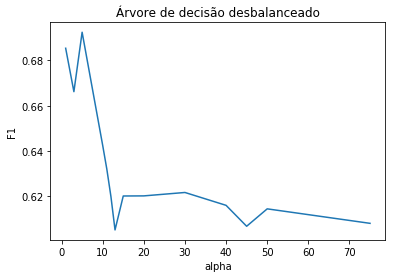

In [31]:
imprimir_f1_alpha(f1_arvores, num_arvores, "Árvore de decisão desbalanceado")

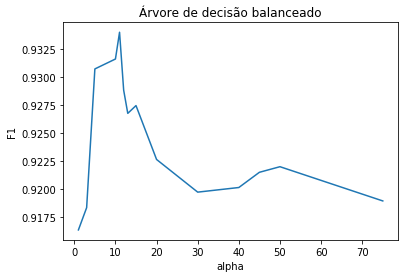

In [32]:
imprimir_f1_alpha(f1_arvores_balanceado, num_arvores, "Árvore de decisão balanceado")

### Melhor modelo

In [42]:
f1_arvores = pd.Series(f1_arvores, index = num_arvores)
f1_arvores_balanceado = pd.Series(f1_arvores_balanceado, index = num_arvores)
arvore = tree.DecisionTreeClassifier(max_depth=f1_arvores.idxmax()).fit(treino, y_treino)
arvore_balanceado = tree.DecisionTreeClassifier(max_depth=f1_arvores_balanceado.idxmax()).fit(treino_balanceado, y_treino_balanceado)
melhor_modelo(arvore, arvore_balanceado)

Desbalanceado
Treino
F-measure: 0.78%
Precisão: 0.72%
Revocação: 0.85% 
ROC AUC: 0.90%
Acurácia: 0.93%
Teste
F-measure: 0.69%
Precisão: 0.56%
Revocação: 0.90% 
ROC AUC: 0.90%
Acurácia: 0.90%
Balanceado
Treino
F-measure: 0.98%
Precisão: 0.97%
Revocação: 0.99% 
ROC AUC: 0.98%
Acurácia: 0.98%
Teste
F-measure: 0.91%
Precisão: 0.88%
Revocação: 0.95% 
ROC AUC: 0.92%
Acurácia: 0.92%


### Regressão Logistica

In [43]:
logistic = LogisticRegression()
logistic.fit(treino, y_treino)
logistic_balanceado = LogisticRegression()
logistic_balanceado.fit(treino_balanceado, y_treino_balanceado)
melhor_modelo(logistic, logistic_balanceado)

C:\Users\luiz_\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\luiz_\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Desbalanceado
Treino
F-measure: 0.75%
Precisão: 0.78%
Revocação: 0.72% 
ROC AUC: 0.84%
Acurácia: 0.93%
Teste
F-measure: 0.73%
Precisão: 0.61%
Revocação: 0.92% 
ROC AUC: 0.92%
Acurácia: 0.91%
Balanceado
Treino
F-measure: 0.95%
Precisão: 0.92%
Revocação: 0.98% 
ROC AUC: 0.94%
Acurácia: 0.94%
Teste
F-measure: 0.92%
Precisão: 0.86%
Revocação: 0.99% 
ROC AUC: 0.92%
Acurácia: 0.92%


### KNN

In [45]:
vizinhos = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75, 100]
f1_knn = [cv(KNeighborsClassifier(n_neighbors=alpha)).mean() 
            for alpha in vizinhos]
f1_knn_balanceado = [cv_balanceado(KNeighborsClassifier(n_neighbors=alpha)).mean() 
            for alpha in vizinhos]

### Encontrar Hiperparametros

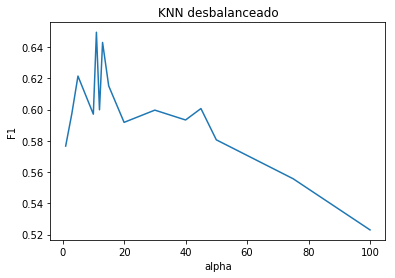

In [46]:
imprimir_f1_alpha(f1_knn, vizinhos, "KNN desbalanceado")

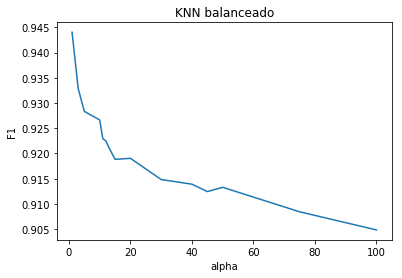

In [47]:
imprimir_f1_alpha(f1_knn_balanceado, vizinhos, "KNN balanceado")

### Melhor modelo

In [48]:
f1_knn = pd.Series(f1_knn, index = vizinhos)
f1_knn_balanceado = pd.Series(f1_knn_balanceado, index = vizinhos)
knn = KNeighborsClassifier(n_neighbors=f1_knn.idxmax()).fit(treino, y_treino)
knn_balanceado = KNeighborsClassifier(n_neighbors=f1_knn_balanceado.idxmax()).fit(treino_balanceado, y_treino_balanceado)
melhor_modelo(knn, knn_balanceado)

Desbalanceado
Treino
F-measure: 0.71%
Precisão: 0.75%
Revocação: 0.67% 
ROC AUC: 0.82%
Acurácia: 0.92%
Teste
F-measure: 0.67%
Precisão: 0.60%
Revocação: 0.77% 
ROC AUC: 0.85%
Acurácia: 0.91%
Balanceado
Treino
F-measure: 1.00%
Precisão: 1.00%
Revocação: 1.00% 
ROC AUC: 1.00%
Acurácia: 1.00%
Teste
F-measure: 0.85%
Precisão: 0.85%
Revocação: 0.85% 
ROC AUC: 0.86%
Acurácia: 0.86%


### Adaboost 

In [49]:
estimadores = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75, 100, 200, 300, 400]
f1_ada = [cv(AdaBoostClassifier(n_estimators=alpha)).mean() 
            for alpha in estimadores]
f1_ada_balanceado = [cv_balanceado(AdaBoostClassifier(n_estimators=alpha)).mean() 
            for alpha in estimadores]

### Encontrar Hiperparametros

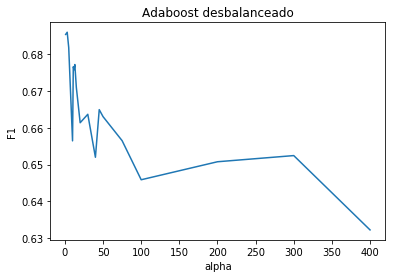

In [50]:
imprimir_f1_alpha(f1_ada, estimadores, "Adaboost desbalanceado")

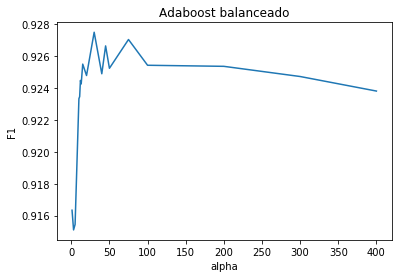

In [51]:
imprimir_f1_alpha(f1_ada_balanceado, estimadores, "Adaboost balanceado")

### Melhor modelo

In [52]:
f1_ada = pd.Series(f1_ada, index = estimadores)
f1_ada_balanceado = pd.Series(f1_ada_balanceado, index = estimadores)
ada = AdaBoostClassifier(n_estimators=f1_ada.idxmax()).fit(treino, y_treino)
ada_balanceado = AdaBoostClassifier(n_estimators=f1_ada_balanceado.idxmax()).fit(treino_balanceado, y_treino_balanceado)
melhor_modelo(ada, ada_balanceado)

Desbalanceado
Treino
F-measure: 0.72%
Precisão: 0.65%
Revocação: 0.80% 
ROC AUC: 0.87%
Acurácia: 0.91%
Teste
F-measure: 0.68%
Precisão: 0.53%
Revocação: 0.94% 
ROC AUC: 0.91%
Acurácia: 0.89%
Balanceado
Treino
F-measure: 0.95%
Precisão: 0.93%
Revocação: 0.97% 
ROC AUC: 0.94%
Acurácia: 0.94%
Teste
F-measure: 0.93%
Precisão: 0.88%
Revocação: 0.99% 
ROC AUC: 0.93%
Acurácia: 0.93%


### Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)

De modo geral os modelos tiveram um bom desempenho quando comparamos os resultados do treino com o teste. Existiram casos de overfit porém está associado a caracteristica do modelo como no caso do KNN. Os resultados obtidos foram bons porém os modelos tiveram melhores resultados com os dados balanceados. Acredito que classificadores com uma acurácia na casa de 90% é um bom resultado dado a complexidade associada com prever resultados de eleições.

### Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)

In [59]:
def importancia_atributos(importancia, colunas):
    coef_ridge = pd.Series(importancia, index = colunas)
    imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])
    matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef_ridge.plot(kind = "barh")
    plt.title("Importância das variáveis")

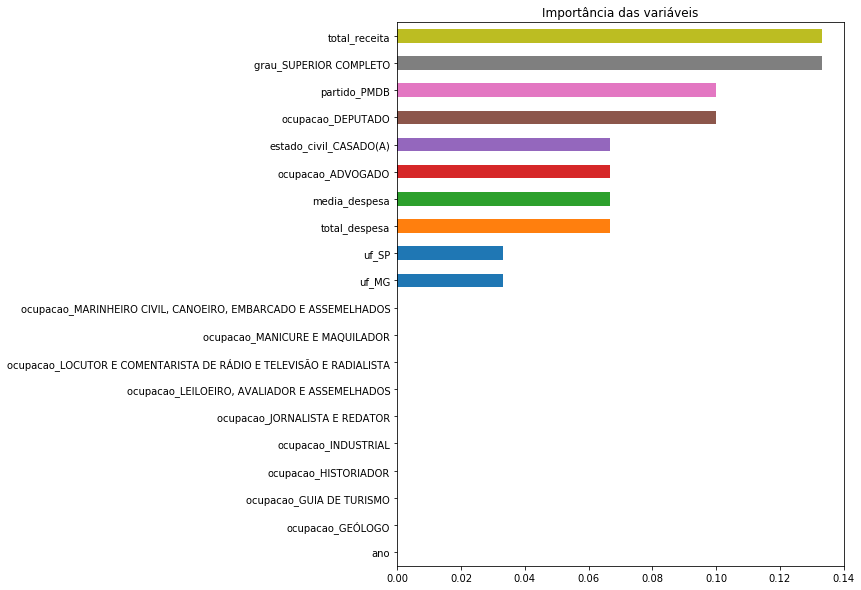

In [60]:
importancia_atributos(ada_balanceado.feature_importances_, treino_balanceado.columns)

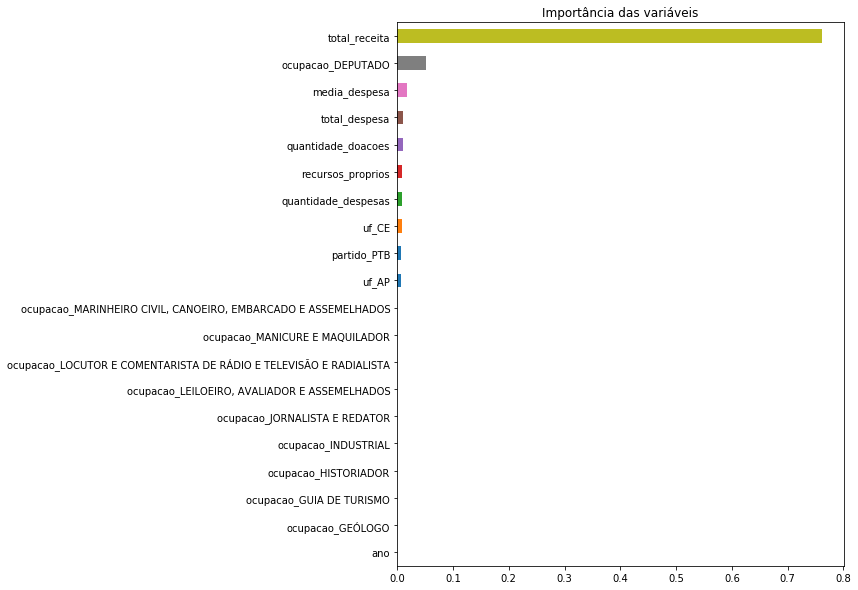

In [61]:
importancia_atributos(arvore_balanceado.feature_importances_, treino_balanceado.columns)

Nos dois modelos o total de receita vem como mais importânte o que faz sentido em uma capanha política pois as oportunidade das propostas chegarem as eleitores são maiores de acordo com a quantidade de dinheiro investido. Na árvore de decisão a maioria dos atributos tão associados de alguma forma com receita, porém, no Adaboost mostra características interessantes como o fato de ser casado e ter ensino superior completo influênciarem no resultado. Mostra uma característica da população em confiar em quem é mais estável na vida.  